In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from itertools import chain
from collections import defaultdict

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
png_files = glob('/data/**/*.png', recursive=True)

In [3]:
def fullname(fname):
    """Given a filename (like 00019124_042.png), returns the full filepath"""
    img = [file for file in png_files if fname in file]
    
    if img[0]:
        return img[0]
    else:
        return None
    
    
def xrayread(fname):
    """Given a filename returns the associated image file"""
    return plt.imread(fullname(fname))


def xrayshow(fname):
    """Given a filename displays the image file via pyplot"""
    return plt.imshow(readxray(fname), cmap='bone')

In [4]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')

In [5]:
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
10320,00002673_016.png,No Finding,16,2673,25,M,PA,2674,2152,0.143000,0.143000,NaN
27940,00007283_004.png,Nodule,4,7283,56,M,PA,2500,2048,0.168000,0.168000,NaN
43813,00011291_003.png,Infiltration|Mass,3,11291,31,M,AP,2500,2048,0.168000,0.168000,NaN
74228,00018237_028.png,Pneumonia,28,18237,30,F,PA,2986,2991,0.143000,0.143000,NaN
109472,00029795_000.png,No Finding,0,29795,48,F,PA,2021,2021,0.194311,0.194311,NaN


# Data Cleaning

These changes were determined largely as a result of EDA but have all been moved to the top so the dataframe is consistent throughout and to keep the "write" code cells separate from the strictly "read" cells. 

In [6]:
print(f"sample_df size: {len(sample_df)}, all_xray_df size: {len(all_xray_df)}")

sample_df size: 5606, all_xray_df size: 112120


## Column Renaming

In [7]:
data = all_xray_df

# Give column names that won't require quotes
colnames = ['ImageIndex', 'FindingLabels', 'FollowupNum', 'PatientID',
       'PatientAge', 'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacingX', 'OriginalImagePixelSpacingY', 'Unnamed: 11']
data.columns = colnames

# Drop the final column which contains no data
data = data[colnames[:-1]]

## Separating out Labels

The radiologists' labels are currently stored in a single string per observation so we should get those in a form that we can query more efficiently. First we get the distinct strings describing conditions. 

In [8]:
label_arrays = data['FindingLabels'].map(lambda x: x.split('|'))
distinct_labels = np.unique(list(chain(*label_arrays)))

Each record now has an array of conditions that look like this:

In [9]:
label_arrays[:5]

0               [Cardiomegaly]
1    [Cardiomegaly, Emphysema]
2     [Cardiomegaly, Effusion]
3                 [No Finding]
4                     [Hernia]
Name: FindingLabels, dtype: object

And all of the distinct labels across the whole dataset are these:

In [10]:
distinct_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

With all that we can create dummy vars for each condition:

In [11]:
for label in distinct_labels:
    vals = [label in array for array in label_arrays]
    data.insert(len(data.columns), label, vals)

In [12]:
data.sample(5)

,ImageIndex,FindingLabels,FollowupNum,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
21074,00005631_000.png,No Finding,0,5631,7,M,PA,2048,2500,0.171,...,False,False,False,False,False,True,False,False,False,False
23273,00006162_002.png,Atelectasis|Consolidation,2,6162,78,M,AP,2500,2048,0.171,...,False,False,False,False,False,False,False,False,False,False
55335,00013866_000.png,No Finding,0,13866,39,M,PA,2992,2991,0.143,...,False,False,False,False,False,True,False,False,False,False
24620,00006474_003.png,No Finding,3,6474,58,M,AP,2500,2048,0.168,...,False,False,False,False,False,True,False,False,False,False
9886,00002562_001.png,Pleural_Thickening,1,2562,18,M,PA,2500,2048,0.171,...,False,False,False,False,False,False,False,True,False,False


These come out as `True` and `False` but Python doesn't have true boolean values--these are just syntactic sugar for 1 and 0 so changing them is a matter of preference and interoperability with other software.

In [13]:
True * False + True

1

Now we can drop the `FindingLabels` column, change gender to categorical, and rename the sole survivor with a space in it

In [14]:
colnames = ['ImageIndex', 'FindingLabels', 'FollowupNum', 'PatientID', 'PatientAge',
       'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacingX',
       'OriginalImagePixelSpacingY', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No_Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax']
data.columns = colnames

cols = ['ImageIndex', 'FollowupNum', 'PatientID', 'PatientAge',
       'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacingX',
       'OriginalImagePixelSpacingY', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No_Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax']
data = data[cols]

data.PatientGender = data.PatientGender.astype('category')

In [15]:
data.head(5)

,ImageIndex,FollowupNum,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No_Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,False,False,False,False,False,False,False,False,False,False
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,True,False,False,False,False,False,False,False,False,False
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,False,False,False,False,False,False,False,False,False,False
3,00000002_000.png,0,2,81,M,PA,2500,2048,0.171,0.171,...,False,False,False,False,False,True,False,False,False,False
4,00000003_000.png,0,3,81,F,PA,2582,2991,0.143,0.143,...,False,False,True,False,False,False,False,False,False,False


## Counting Conditions

Add a column that indicates the total number of conditions (other than `No Finding`) indicated in the observations.

In [16]:
conditions = ['Atelectasis', 
              'Cardiomegaly', 
              'Consolidation', 
              'Edema',
              'Effusion', 
              'Emphysema', 
              'Fibrosis', 
              'Hernia', 
              'Infiltration',
              'Mass', 
              'Nodule', 
              'Pleural_Thickening', 
              'Pneumonia',
              'Pneumothorax']

In [17]:
conditions_count = data[conditions].sum(axis=1)

In [18]:
data['TotalConditions'] = conditions_count
data.sample(5)

,ImageIndex,FollowupNum,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY,...,Fibrosis,Hernia,Infiltration,Mass,No_Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,TotalConditions
79438,00019513_002.png,2,19513,55,F,PA,2630,2681,0.143,0.143,...,False,False,False,True,False,True,False,False,False,2
4747,00001270_003.png,3,1270,39,F,PA,2048,2500,0.168,0.168,...,False,False,False,False,True,False,False,False,False,0
69261,00017098_003.png,3,17098,67,F,AP,2500,2048,0.168,0.168,...,False,False,False,False,False,True,False,False,False,1
737,00000181_040.png,40,181,50,F,AP,2500,2048,0.168,0.168,...,False,False,False,False,False,False,False,False,False,1
75268,00018465_002.png,2,18465,62,M,PA,2992,2991,0.143,0.143,...,False,False,False,False,True,False,False,False,False,0


In [19]:
def cond_count(cond):
    return len(data[data[cond] == True])

def cond_percentage(cond):
    return (cond_count(cond) / len(data))

# Approach and Clinical Basis

I am approaching this problem somewhat differently than a simple binary classification for the `Pneumonia` label. Having discussed the problem with some medical professionals they indicated that `Pneumonia`, `Infiltration`, and `Consolidation` could all be used to describe the kind of structures that indicate pneumonia, and that the choice of label relies on the particular radiologist. In other words an image that radiologist A might label `Pneumonia` gets labeled as `Consolidation` by radiologist B, but both of these labels describe the same structures and findings.

This is inimical to the function of the CNN algorithm because we are asking the neural net to learn the patterns and structures associated with the presence pneumonia (the positive class) as well as the patterns and structures associated with the absence of pneumonia (the negative class) but in many cases these will be the same structures so the algorithm will have extreme difficulty learning. 

The problem can be approached in two ways. First, we could train the `Pneumonia` class solely against images that contain `No Finding` so we know we aren't causing labeling problems. Second, we could expand the positive class to include more labels that are commonly indicative of pneumonia. In talking to clinical experts the ones identified by all participants were `Consolidation`, `Infiltration`, and `Atelectasis` as being closely related to pneumonia. Secondarily `Effusion` and `Edema` could be caused by pneumonia.

As the dataset already contains a very small number of pneumonia images (1,431 or ~1.3% of the total) I've chosen to expand the positive class with additional labels that can indicate pneumonia with the intention of creating an algorithm that can flag x-rays for a more detailed follow-up. 

For that reason I'll start by examining these related attributes before defining the positive and negative classes and then moving on to the typical EDA.

In [20]:
print(cond_count('Pneumonia'), ' | ', len(data), ' | ', cond_percentage('Pneumonia'))

1431  |  112120  |  0.012763110952550838


## Examining Related Conditions

### Pneumonia Co-Morbidity

As stated before conditions related to `Pneumonia` as identified by medical experts are `Atelectasis`, `Consolidation`, and `Infiltratation`. First we'll look at co-morbidity with our base class of `Pneumonia` and see how those compare.

In [21]:
cocc = data[conditions].astype(int).T.dot(data[conditions].astype(int))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

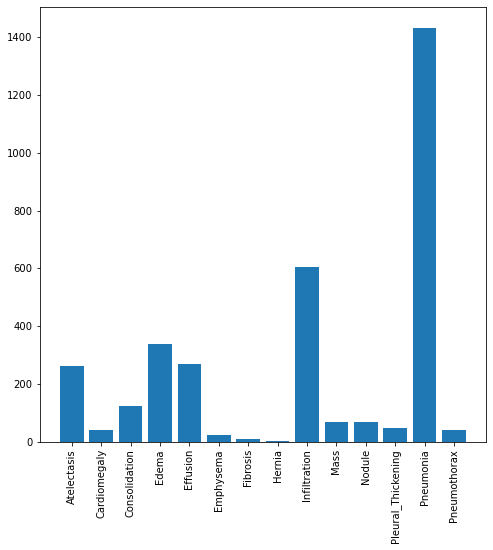

In [22]:
plt.figure(figsize=(8,8))
plt.bar(conditions, cocc['Pneumonia'])
plt.xticks(rotation='vertical')

All of our related conditions have high co-morbidity with pneumonia indicating that there is value in this. `Edema` and `Effusion` also show high co-morbidity, which were noted by our experts as being related but of lesser correlation. Further, they should not necessarily look similar on an x-ray. In other words there are initially strong reasons _not_ to include these in the positive class.

### Edema and Effusion

In [23]:
print(f"Edema: {cond_count('Edema')} | Effusion: {cond_count('Effusion')}")

Edema: 2303 | Effusion: 13317


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

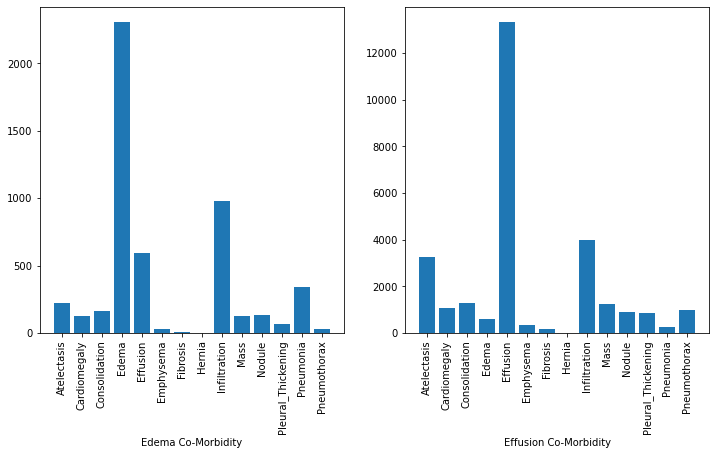

In [24]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.xlabel('Edema Co-Morbidity')
plt.bar(conditions, cocc['Edema'])
plt.xticks(rotation='vertical')

plt.subplot(1, 2, 2)
plt.xlabel('Effusion Co-Morbidity')
plt.bar(conditions, cocc['Effusion'])
plt.xticks(rotation='vertical')

`Effusion` has a large number of cases and `Pneumonia` has very low co-morbidity with it. Expert advice suggests that it is not a great indicator for pneumonia as well. Including it in the positive class would likely generate a large number of false positives.

`Edema` is slightly better with both `Infiltration` and `Pneumonia` being more highly correlated with it, but again it would likely generate false positives as it can stem from other sources and seems unlikely to be of benefit.

### Atelectasis, Consolidation, and Infiltration

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

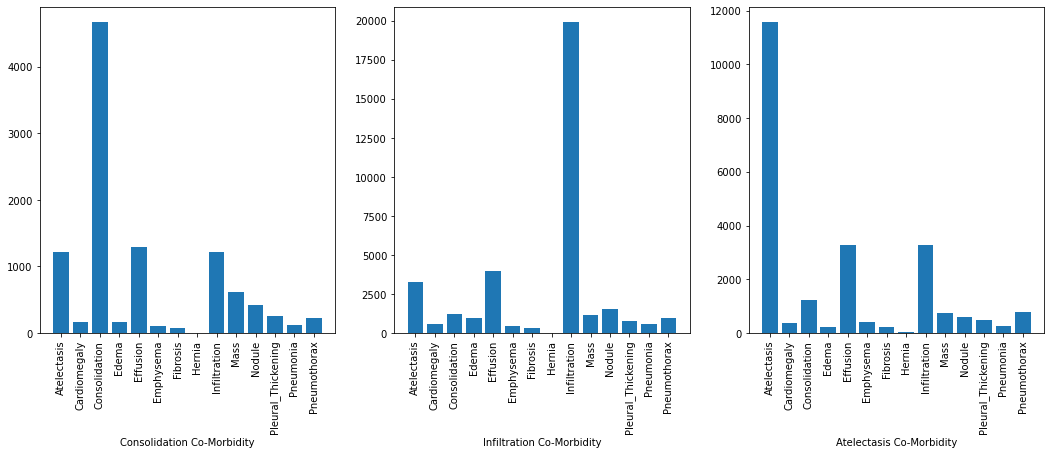

In [25]:
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.xlabel('Consolidation Co-Morbidity')
plt.bar(conditions, cocc['Consolidation'])
plt.xticks(rotation='vertical')

plt.subplot(1, 3, 2)
plt.xlabel('Infiltration Co-Morbidity')
plt.bar(conditions, cocc['Infiltration'])
plt.xticks(rotation='vertical')

plt.subplot(1, 3, 3)
plt.xlabel('Atelectasis Co-Morbidity')
plt.bar(conditions, cocc['Atelectasis'])
plt.xticks(rotation='vertical')

Looking strictly at correlation with other conditions there is an initial problem here. None of them have a high co-morbidity with `Pneumonia` relative to other conditions. Since we are ultimately trying to identify pneumonia this would argue for non-inclusion, but it's not that simple. 

As we've established already `Pneumonia` makes up a very small percentage of the dataset, and these conditions are highly correlated when we know that `Pneumonia == True` so part of this comes from the relative size of these datasets (eg: 1,400 for pneumonia and 20,000 for infiltration). Based off of the data for pneumonia specifically we have an argument for including these.

Second, and much more significantly, in talking to expert sources the ultimate problem here is that pneumonia _cannot_ be truly diagnosed from a chest x-ray so ultimately the labels describe what _is_ visible and should be followed-up on.

Based on the EDA and discussions with industry professionals it seems that the positive class should be:

`Pneumonia` $\cup$ `Consolidation` $\cup$ `Infiltration`

Excluding `Atelectasis` here stems from the fact that it is more often a side-effect of pneumonia, and there are a large number of observations for that class which may dilute what we are asking the CNN to find. 

The negative class is harder to determine. Depending on results it might be best to train against _only_ `No_Finding` x-rays, however in validation we will need to consider its performance against a wider range of samples, such as x-rays containing `Mass` or `Pneumothorax`. Preliminarily, however, we will look at just our positive class versus "clean" x-rays.

# EDA on Positive/Negative/Extended Sets

So our total set is `data`, the positive cases are where `Pneumonia_Like == True`, we'll also define and look at the `No_Finding == True` cases on their own, and define a final dataframe that contains all the x-rays that _did_ contain findings but none were in our list of findings to look for (eg: `Mass` and nothing else).

In [26]:
positives = ['Pneumonia', 'Consolidation', 'Infiltration']
data["Pneumonia_Like"] = data[positives].sum(axis=1) > 0

pos_data = data[data.Pneumonia_Like == True]
neg_data = data[data.No_Finding == True]
non_pos_data = data[(data.Pneumonia_Like == False) & (data.No_Finding == False)]

We have significantly increased the number of positive images that can indicate pneumonia.

In [28]:
print(f"Positive Cases: {len(pos_data)}\nNo Finding: {len(neg_data)}\nNon-Positives: {len(non_pos_data)}")

Positive Cases: 24084
No Finding: 60361
Non-Positives: 27675


All told the positives make up about 21.5% of all cases now.

In [29]:
len(pos_data) / len(data)

0.2148055654655726

## Age and Gender

Next we can look at specific attributes of the dataset as well as in the pneumonia-specific set. We'll start with age and gender.

In [30]:
data[['PatientAge', 'PatientGender']].describe(include='all')

,PatientAge,PatientGender
count,112120.000000,112120
unique,NaN,2
top,NaN,M
freq,NaN,63340
mean,46.901463,NaN
std,16.839923,NaN
min,1.000000,NaN
25%,35.000000,NaN
50%,49.000000,NaN
75%,59.000000,NaN


Right off we see a problem with age since we have a max of 414 years old in the overall dataset. Let's dig deeper. 

In [31]:
data[data.PatientAge > 200]

,ImageIndex,FollowupNum,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY,...,Hernia,Infiltration,Mass,No_Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,TotalConditions,Pneumonia_Like
20852,00005567_000.png,0,5567,412,M,AP,3056,2544,0.139,0.139,...,False,False,False,False,False,False,True,False,2,True
46965,00011973_002.png,2,11973,414,M,AP,3056,2544,0.139,0.139,...,False,False,False,False,False,False,False,False,1,False
84810,00020900_002.png,2,20900,411,M,AP,3056,2544,0.139,0.139,...,False,False,False,True,False,False,False,False,0,False
85404,00021047_002.png,2,21047,412,M,AP,3056,2544,0.139,0.139,...,False,False,True,False,False,True,False,False,2,False
86264,00021275_003.png,3,21275,413,F,AP,3056,2544,0.139,0.139,...,False,False,False,True,False,False,False,False,0,False
91369,00022811_000.png,0,22811,412,M,PA,3056,2544,0.139,0.139,...,False,False,False,True,False,False,False,False,0,False


Aside from the intuition that even one 400-year-old person is impossible, we actually have six. Let's go ahead and threshold our algorithm on age. Let's limit it to 80 and younger, which is still clinically useful but narrows what we're looking at a bit. First we analyze the impact of that. 

In [32]:
len(data[data.PatientAge > 80])

897

In [33]:
len(pos_data[pos_data.PatientAge > 80])

215

Of 897 total cases 215 are in our positive group, which is acceptable.

In [34]:
data = data[data.PatientAge <= 80]
pos_data = pos_data[pos_data.PatientAge <= 80]
neg_data = neg_data[neg_data.PatientAge <= 80]
non_pos_data = non_pos_data[non_pos_data.PatientAge <= 80]

With extreme values removed we can look at the histograms of age.

Text(0.5, 0, 'Patient Age (Non-Positives)')

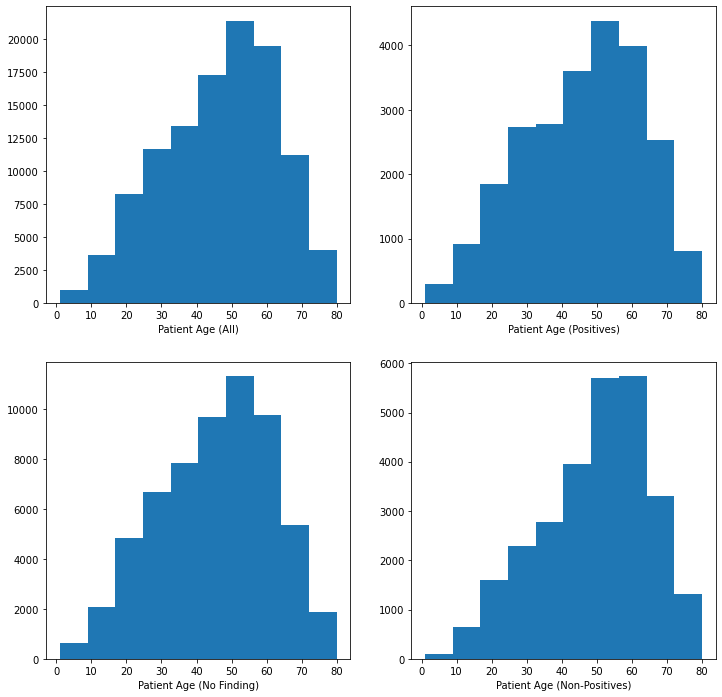

In [35]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.hist(data.PatientAge, bins=10)
plt.xlabel('Patient Age (All)')

plt.subplot(2, 2, 2)
plt.hist(pos_data.PatientAge, bins=10)
plt.xlabel('Patient Age (Positives)')

plt.subplot(2, 2, 3)
plt.hist(neg_data.PatientAge, bins=10)
plt.xlabel('Patient Age (No Finding)')

plt.subplot(2, 2, 4)
plt.hist(non_pos_data.PatientAge, bins=10)
plt.xlabel('Patient Age (Non-Positives)')

The `No Finding` group corresponds closely with the dataset as a whole (`All`). The `Positive` group skews older than either of those, but not as significantly as the `Non-Positive` group consisting of all the images with findings consisting solely of non-pneumonia-specific symptoms.

Text(0.5, 0, 'Patient Gender (Non-Positives)')

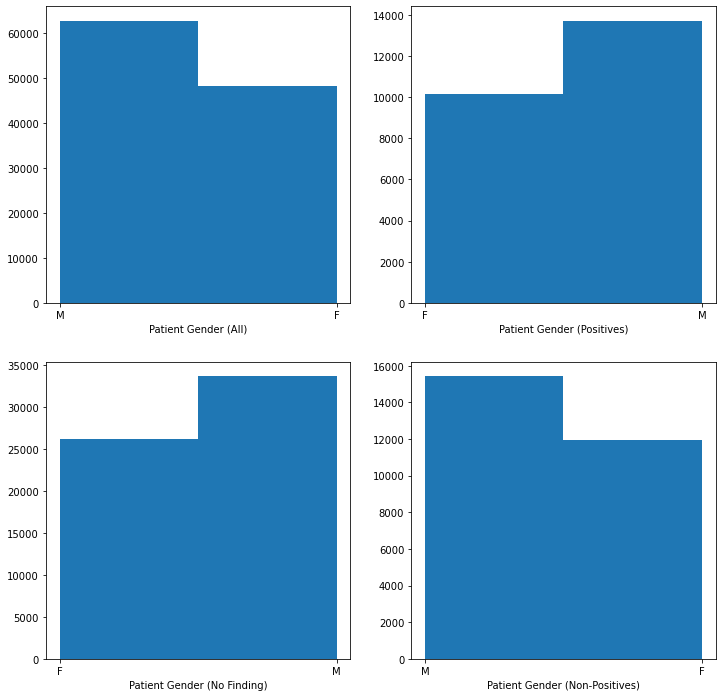

In [36]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.hist(data.PatientGender, bins=2)
plt.xlabel('Patient Gender (All)')

plt.subplot(2, 2, 2)
plt.hist(pos_data.PatientGender, bins=2)
plt.xlabel('Patient Gender (Positives)')

plt.subplot(2, 2, 3)
plt.hist(neg_data.PatientGender, bins=2)
plt.xlabel('Patient Gender (No Finding)')

plt.subplot(2, 2, 4)
plt.hist(non_pos_data.PatientGender, bins=2)
plt.xlabel('Patient Gender (Non-Positives)')

Despite the tendency of pyplot to swap the ordering all of these have more males than females and by similar proportions.

## Total Conditions

To get a sense of the general condition of the patients for the different groups let's look at the total number of conditions identified in a single image.

Text(0.5, 0, 'Total Conditions in Image (Non-Positives)')

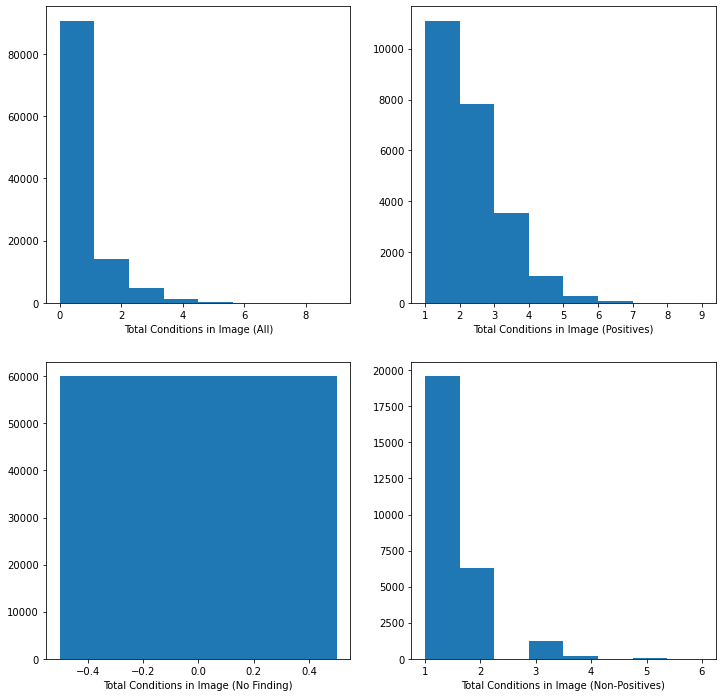

In [37]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.hist(data.TotalConditions, bins=8)
plt.xlabel('Total Conditions in Image (All)')

plt.subplot(2, 2, 2)
plt.hist(pos_data.TotalConditions, bins=8)
plt.xlabel('Total Conditions in Image (Positives)')

plt.subplot(2, 2, 3)
plt.hist(neg_data.TotalConditions, bins=1)
plt.xlabel('Total Conditions in Image (No Finding)')

plt.subplot(2, 2, 4)
plt.hist(non_pos_data[non_pos_data.No_Finding == False].TotalConditions, bins=8)
plt.xlabel('Total Conditions in Image (Non-Positives)')

By definition `No Finding` images have zero conditions, as for the rest we see that in the full (`All`) dataset zero conditions is the most common followed distantly by a small number of conditions (2 or less). While our `Positive` cases still typically have only one or two conditions listed, there is a longer tail in which we see a statistically significant number that have more than five conditions. Contrasting this with the `Non-Positive` group we see that those images contain one or two conditions nearly always, with only an outlier group containing three to four findings.

All in all this supports our redefinition of the positive group. Since pneumonia can cause a range of symptoms that appear under different labels we are expecting to see pneumonia-like symptoms appear in groups, and treating them as a combined class should improve accuracy.

Having said that, we are only training a CNN for binary classification. If we were working with a clinical partner we would probably ask for images that only show pneumonia-like symptoms and it's unlike that we would get these from an image contains six or seven findings. For this reason we can justify eliminating high-condition-count images from the training set.

In [38]:
sum(pos_data['TotalConditions'] > 3)

1405

In [39]:
sum(pos_data['TotalConditions'] > 3) / len(pos_data)

0.058862960325107884

Dropping everyone with four or more conditions only loses about 5.9% of our total training cases. 

**TODO:** Consider establishing different sets. 

- The definite positives that contain one of more of `[Pneumonia, Consolidation, Infiltration]`
- The definite negatives that are labeled `No Finding`
- A third set that uses the related terms of `[Atelectasis, Effusion, Edema]` in one of two ways:
    - Blacklist any row that contains a finding **not** part of the definite positives or related terms
    - Whitelist any row that contains at least one of the definite positives or whitelisted terms
- A final set that's more about identifying rows that contain _only_ terms we are not interested in. Like a row containing `Mass` but nothing else

## View Position

We have two values `PA` and `AP` of which `AP` makes up about 56% of the total pneumonia images. Among the other images `PA` is the more common value. The two values refer to anteroposterior and posteroanterior imaging.

- **Anteroposterior:** X-Rays are fired through the patient from the front and collected on a detector at their back. Some indication that this is not the overall preferred method, but can be used when the patient might not be able to stand for a posteroanterior X-Ray
- **Posteroanterior:** The rays are fired from behind the patient with the image receptor in front of them.

Text(0.5, 0, 'View Position (Non-Positives)')

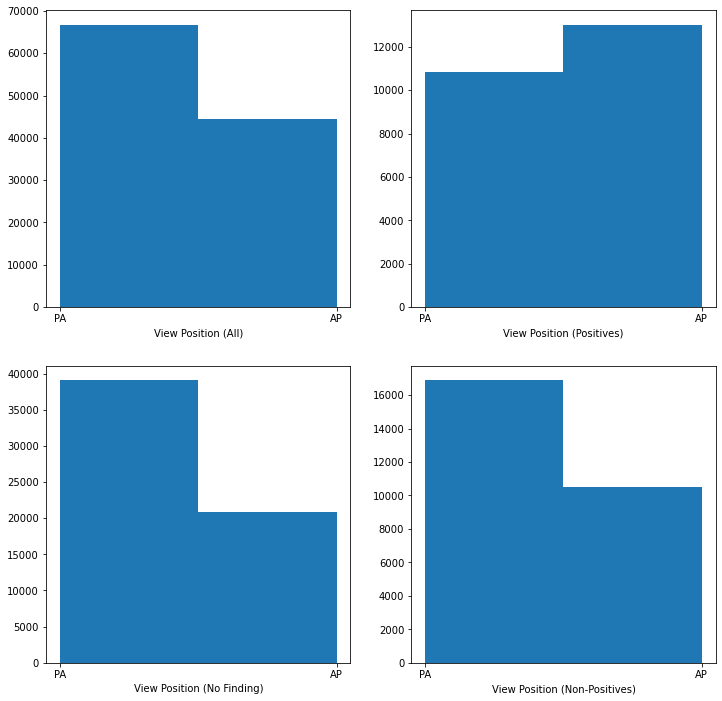

In [40]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.hist(data.ViewPosition, bins=2)
plt.xlabel('View Position (All)')

plt.subplot(2, 2, 2)
plt.hist(pos_data.ViewPosition, bins=2)
plt.xlabel('View Position (Positives)')

plt.subplot(2, 2, 3)
plt.hist(neg_data.ViewPosition, bins=2)
plt.xlabel('View Position (No Finding)')

plt.subplot(2, 2, 4)
plt.hist(non_pos_data.ViewPosition, bins=2)
plt.xlabel('View Position (Non-Positives)')

In [41]:
len(data[data.ViewPosition == 'PA']) / len(data)

0.6003794179261484

In [42]:
n_patients = len(np.unique(data['PatientID']))
n_patients

30548

In [43]:
len(data) / n_patients

3.6409257561869843

`PA` is more common in every set but the positives set, which is an interesting finding. A few things to note here:

- The total number of patients (by unique patient ID) is roughly 30K for a set of 112K images, we end up with about 3.6 images per patient. 
- Anteroposterior (AP) views are possible when the patient cannot stand and are instead taken while they are in the hospital bed. Intuitively people who are struggling to breathe are more likely to be in this group, which could explain the higher occurence in the positives group. 

First off we see that there are actually ~3.6 images per patient in our dataset so some of these are certainly just x-rays taken from both directions in the same session. Beyond that PA can be used for patients unable to stand, whereas AP typically is not. So for every AP image we probably have a matching PA image, whereas the opposite is not necessarily true.

Finally we'll visualize some of the images of each type:

In [44]:
len(pos_data[pos_data.ViewPosition == 'AP'])

13026

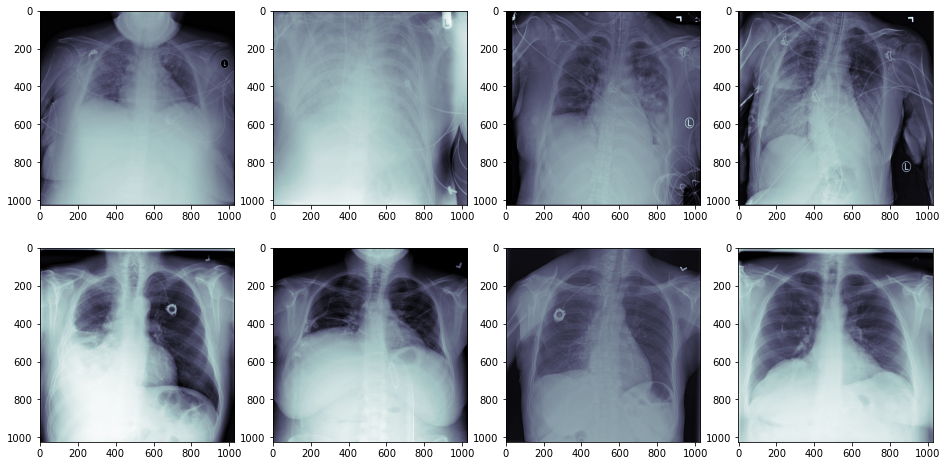

In [45]:
ap = pos_data[pos_data.ViewPosition == 'AP'].sample(4)['ImageIndex']
pa = pos_data[pos_data.ViewPosition == 'PA'].sample(4)['ImageIndex']

views = ap.append(pa)

plt.figure(figsize=(16, 8))

for i in range(len(views)):
    plt.subplot(2, 4, i+1)
    plt.imshow(xrayread(views.iloc[i]), cmap='bone')

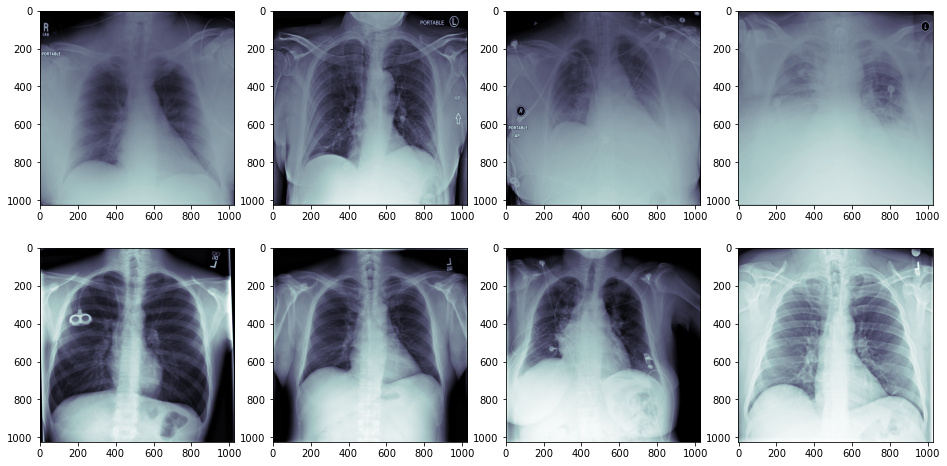

In [46]:
ap = neg_data[neg_data.ViewPosition == 'AP'].sample(4)['ImageIndex']
pa = neg_data[neg_data.ViewPosition == 'PA'].sample(4)['ImageIndex']

views = ap.append(pa)

plt.figure(figsize=(16, 8))

for i in range(len(views)):
    plt.subplot(2, 4, i+1)
    plt.imshow(xrayread(views.iloc[i]), cmap='bone')

From an algorithm standpoint both of these views can be useful as they provide imaging of the same region. 

## Pixel-Level Analysis

Here we'll look at the histograms of healthy vs. random vs. pneumonia images. Since we have a different dataframe provided for pixel-level analysis we need to replicate some of the modifications we've made above. 

In [47]:
pixel_data = sample_df

colnames = ['ImageIndex', 'FindingLabels', 'FollowupNum', 'PatientID',
       'PatientAge', 'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacingX', 'OriginalImagePixelSpacingY']
pixel_data.columns = colnames

In [48]:
label_arrays = pixel_data['FindingLabels'].map(lambda x: x.split('|'))
distinct_labels = np.unique(list(chain(*label_arrays)))

for label in distinct_labels:
    vals = [label in array for array in label_arrays]
    pixel_data.insert(len(pixel_data.columns), label, vals)

In [49]:
positives = ['Pneumonia', 'Consolidation', 'Infiltration']
pixel_data["Pneumonia_Like"] = pixel_data[positives].sum(axis=1) > 0

In [50]:
pos_pixel_data = pixel_data[pixel_data.Pneumonia_Like == True]
neg_pixel_data = pixel_data[pixel_data['No Finding'] == True]
non_pos_pixel_data = pixel_data[(pixel_data.Pneumonia_Like == False) & (pixel_data['No Finding'] == False)]

In [51]:
names = ['Positives', 'Negatives', 'Non-Positives']
arrs = [pos_pixel_data, neg_pixel_data, non_pos_pixel_data]

for i in range(len(names)):
    print(f"{names[i]}: {len(arrs[i])}")

Positives: 1167
Negatives: 3044
Non-Positives: 1395


We only have 62 total images with Pneumonia so we'll sample from these to make histograms

In [52]:
sample_size = 20

all_pixel_imgs = pixel_data.sample(sample_size)['ImageIndex']
pos_pixel_imgs = pos_pixel_data.sample(sample_size)['ImageIndex']
neg_pixel_imgs = neg_pixel_data.sample(sample_size)['ImageIndex']
non_pos_pixel_imgs = non_pos_pixel_data.sample(sample_size)['ImageIndex']

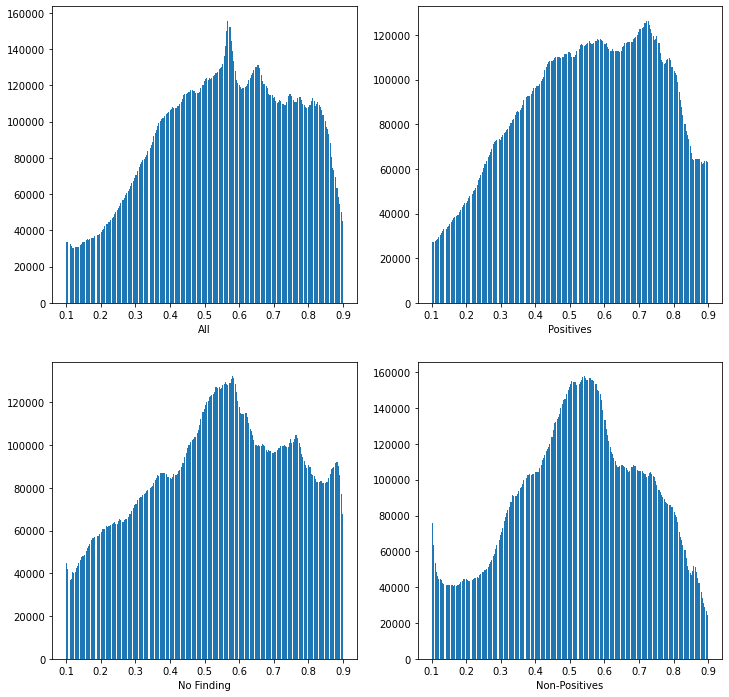

In [53]:
plt.figure(figsize=(12, 12))

samples = [all_pixel_imgs, pos_pixel_imgs, neg_pixel_imgs, non_pos_pixel_imgs]
names = ['All', 'Positives', 'No Finding', 'Non-Positives']

for i in range(len(samples)):
    pixel_vals = []
    for row in samples[i]:
        img = xrayread(row)
        pixel_vals.extend(img.ravel())
        
    
    plt.subplot(2, 2, i+1)
    plt.xlabel(names[i])
    plt.hist(pixel_vals, bins=256, range=(0.1, 0.9))

Different random samples of 20 give significantly different histograms suggesting that there isn't enough of a systemic difference between the different classes to be of much help in classification. 

## Visualizing the images

## Positive Images

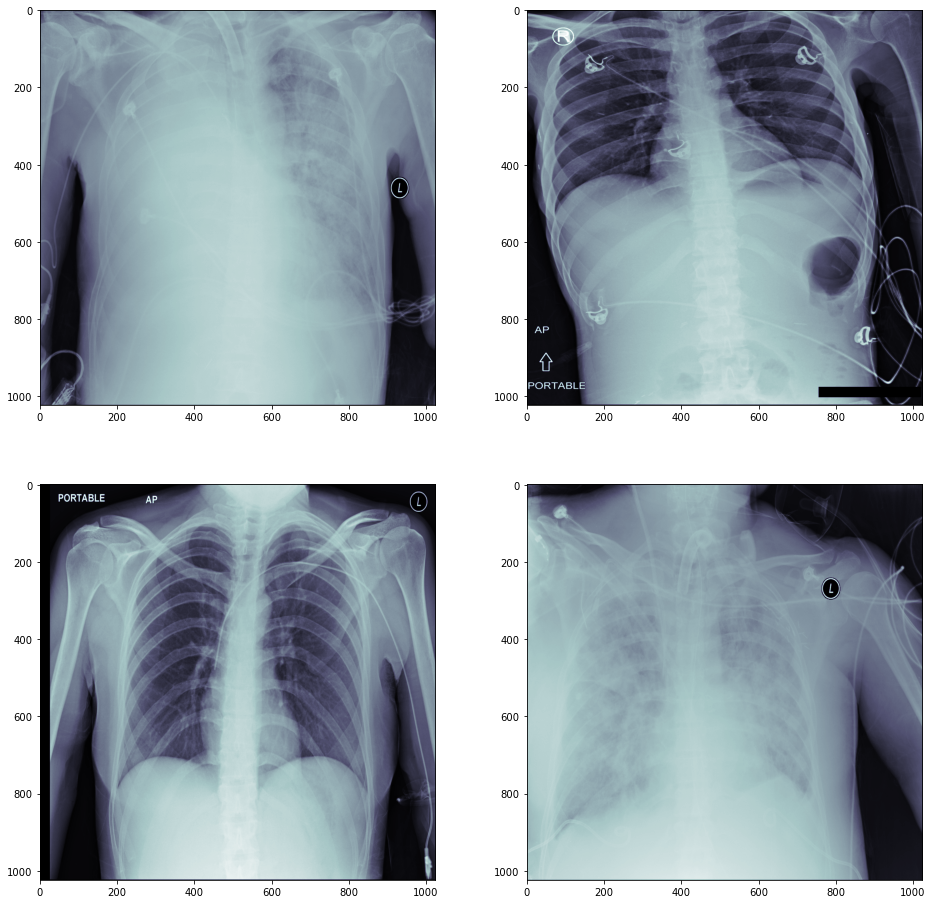

In [54]:
sample_images = pos_data.sample(4)['ImageIndex']
plt.figure(figsize=(16, 16))
for i in range(len(sample_images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(xrayread(sample_images.iloc[i]), cmap='bone')

## No Finding Images

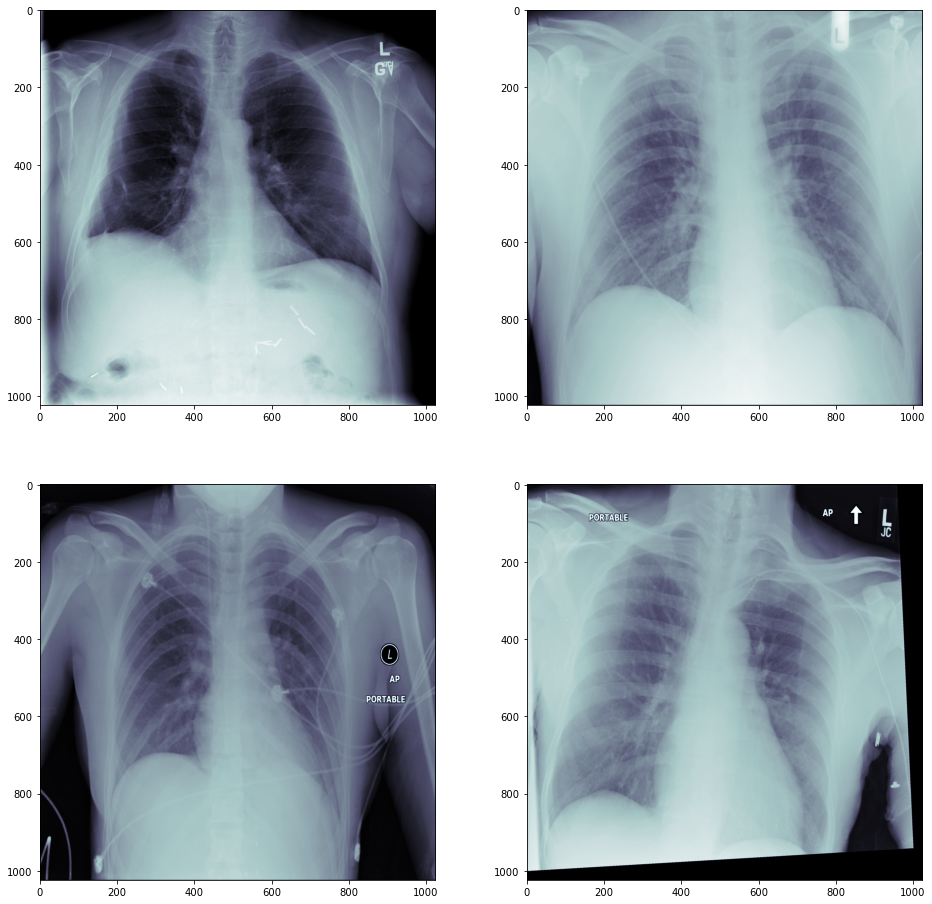

In [55]:
sample_images = neg_data.sample(4)['ImageIndex']
plt.figure(figsize=(16, 16))
for i in range(len(sample_images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(xrayread(sample_images.iloc[i]), cmap='bone')

The main takeaway from our own visualizations is that within the dataset as a whole, as well as within specific groups (like `Pneumonia == True`) there is a lot of variation with different view positions, patient positions, the overall brightness level of the image, male versus female images, the presence of electrodes, etc. For an algorithm to be clinically useful it should be able to cut through the noise on these scans but it is undoubtedly a difficult task.